## **09-2) 순환 신경망으로 IMDB 리뷰 분류하기**

텐서플로를 사용해 순환 신경망을 만들어 영화 리뷰 데이터셋에 적용해서 리뷰를 긍정과 부정으로 분류한다.

#### **용어 정리**
- **말뭉치**(corpus): 자연어 처리에서 사용하는 텍스트 데이터의 모음 = 훈련 데이터셋
- **토큰**: 텍스트에서 공백으로 구분되는 문자열. 종종 소문자로 변환하고 구둣점은 삭제한다.
- **원-핫 인코딩**: 어떤 클래스에 해당하는 원소만 1이고 나머지는 모두 0인 벡터. 정수로 변환된 토큰을 원-핫 인코딩으로 변환하려면 어휘 사전 크기의 벡터가 만들어진다.
- **단어 임베딩**: 정수로 변환된 토큰을 비교적 작은 크기의 실수 밀집 벡터로 변환한다. 이런 밀집 벡터는 단어 사이의 관계를 표현할 수 있기 때문에 자연어 처리에서 좋은 성능을 발휘한다.

<br><hr><br>

### **IMDB 리뷰 데이터셋**

IMDB 리뷰 데이터셋은 imdb.com에서 수집한 리뷰를 감상평에 따라 긍정과 부정으로 분류해 놓은 데이터셋으로,<br>
총 50,000개의 샘플로 이루어져 있고 훈련 데이터와 테스트 데이터에 각각 25,000개씩 나누어져 있다.

컴퓨터에서 처리하는 모든 것은 어떤 숫자 데이터이기 때문에 텍스트 데이터의 경우 단어를 숫자로 변환하는 과정이 필요하다.<br>
일반적인 방법으로는 데이터에 등장하는 단어마다 고유한 정수를 부여하는 것이다.<br>
단어에 매핑되는 정수는 단어의 의미나 크기와 관련이 없다.

일반적으로 영어 문장은 모두 소문자로 바꾸고 구둣점을 삭제한 다음 공백 기준으로 분리하는데, 이렇게 분리된 단어를 **토큰**이라고 한다.<br>
하나의 샘플은 여러 개의 토큰으로 이루어져 있고, 1개의 토큰이 하나의 타임스텝에 해당한다.

토큰에 할당하는 정수 중 몇 개는 특정 용도로 예약되어 있다. 예를 들어 0은 패딩, 1은 문장의 시작, 2는 어휘 사전에 없는 토큰을 나타낸다.<br>
+) **어휘 사전**: 훈련 세트에서 고유한 단어를 뽑아 만든 목록

IMDB 리뷰 데이터셋은 영어로된 문장이지만 텐서플로에는 이미 정수로 바꾼 데이터가 포함되어 있다.<br>
아래와 같이 tensorflow.keras.datasets 패키지 아래 imdb 모듈을 임포트하여 사용하면 된다.

In [1]:
from tensorflow.keras.datasets import imdb

# num_words=500 ~> 전체 데이터셋에서 가장 자주 등장하는 단어 500개만 사용
(train_input, train_target), (test_input, test_target) = imdb.load_data(num_words=500)

17473536/17464789 [==============================] - 0s 0us/step


훈련 세트와 테스트 세트의 크기를 확인해보자.

In [2]:
print(train_input.shape, test_input.shape)

(25000,) (25000,)


IMDB 리뷰 텍스트는 길이가 제각각이기 때문에 개별 리뷰는 각각 파이썬 리스트 객체로 이루어져 있다. <br>
따라서 훈련 세트와 테스트 세트는 1차원 배열이 된다.

첫 번째 리뷰와 두 번째 리뷰의 길이를 출력해보자.

In [4]:
print(len(train_input[0]))
print(len(train_input[1]))

218
189


리뷰마다 길이가 다른 것을 확인할 수 있다. 이제 첫 번째 리뷰에 담긴 내용을 출력해보자.

In [5]:
print(train_input[0])

[1, 14, 22, 16, 43, 2, 2, 2, 2, 65, 458, 2, 66, 2, 4, 173, 36, 256, 5, 25, 100, 43, 2, 112, 50, 2, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 2, 2, 17, 2, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2, 19, 14, 22, 4, 2, 2, 469, 4, 22, 71, 87, 12, 16, 43, 2, 38, 76, 15, 13, 2, 4, 22, 17, 2, 17, 12, 16, 2, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2, 2, 16, 480, 66, 2, 33, 4, 130, 12, 16, 38, 2, 5, 25, 124, 51, 36, 135, 48, 25, 2, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 2, 15, 256, 4, 2, 7, 2, 5, 2, 36, 71, 43, 2, 476, 26, 400, 317, 46, 7, 4, 2, 2, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2, 56, 26, 141, 6, 194, 2, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 2, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 2, 88, 12, 16, 283, 5, 16, 2, 113, 103, 32, 15, 16, 2, 19, 178, 32]


텐서플로에 있는 IMDB 리뷰 데이터는 이미 정수로 변환되어 있으며, 앞서 num_words=500으로 지정했기 때문에 어휘 사전에는 500개의 단어만 들어있다.<br>
어휘 사전에 없는 단어는 모두 2로 표시되어 있다.

이번에는 타깃 데이터를 출력해보자.

In [6]:
print(train_target[:20])

[1 0 0 1 0 0 1 0 1 0 1 0 0 0 0 0 1 1 0 1]


해결해야 할 문제는 리뷰가 긍정(1)인지 부정(0)인지 판단하는 것이므로 이진 분류로 볼 수 있다.

훈련 세트에서 검증 세트를 분리해보자.<br>
20% 세트로 떼어 놓았으므로 훈련 세트의 크기는 20,000개로 줄어들 것이다.

In [7]:
from sklearn.model_selection import train_test_split

train_input, val_input, train_target, val_target = train_test_split(train_input, train_target, test_size=0.2, random_state=42)

이제 훈련 세트에 대해 몇 가지 조사를 해볼 것이다. 먼저 각 리뷰의 길이를 계산해 넘파이 배열에 담을 것이다.<br>
평균적인 리뷰의 길이와 가장 짧은 리뷰의 길이, 가장 긴 리뷰의 길이를 확인할 것이기 때문이다.

In [8]:
import numpy as np
lengths = np.array([len(x) for x in train_input])

In [9]:
# 리뷰 길이의 평균값과 중간값 구하기
print(np.mean(lengths), np.median(lengths))

239.00925 178.0


리뷰의 평균 단어 개수가 239개, 중간값이 178인 것으로 보아 이 리뷰 길이 데이터는 한쪽으로 치우친 분포를 보일 것으로 예상된다.

lengths 배열을 히스토그램을 표현해보자.

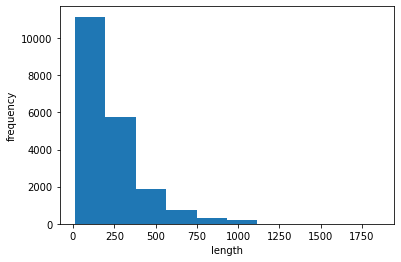

In [10]:
import matplotlib.pyplot as plt

plt.hist(lengths)
plt.xlabel('length')
plt.ylabel('frequency')
plt.show()

역시 한쪽으로 치우친 것을 확인할 수 있다. 대부분의 리뷰 길이가 300미만이다.

리뷰는 대부분 짧아서 여기에서는 중간값보다 훨씬 짧은 100개의 단어만 사용할 것이다.<br>
그러나 100개 단어보다 작은 리뷰가 있기 때문에 이 리뷰들의 길이를 100에 맞추기 위해 패딩을 할 것이다. <br>
보통 패딩을 나타내는 토큰으로는 0을 사용한다.

케라스는 시퀀스 데이터의 길이는 맞춰주는 pad_sequences() 함수를 제공한다.

In [11]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

# maxlen보다 긴 경우는 잘라내고, 짧은 경우는 0으로 패딩
train_seq = pad_sequences(train_input, maxlen=100)

In [12]:
print(train_seq.shape)

(20000, 100)


길이를 100으로 맞춘 train_seq는 이제 (20000, 100) 크기의 2차원 배열이 되었다.

train_seq에 있는 첫 번째 샘플을 출력해보자.

In [13]:
print(train_seq[0])

[ 10   4  20   9   2 364 352   5  45   6   2   2  33 269   8   2 142   2
   5   2  17  73  17 204   5   2  19  55   2   2  92  66 104  14  20  93
  76   2 151  33   4  58  12 188   2 151  12 215  69 224 142  73 237   6
   2   7   2   2 188   2 103  14  31  10  10 451   7   2   5   2  80  91
   2  30   2  34  14  20 151  50  26 131  49   2  84  46  50  37  80  79
   6   2  46   7  14  20  10  10 470 158]


In [14]:
print(train_input[0][-10:])

[6, 2, 46, 7, 14, 20, 10, 10, 470, 158]


pad_sequences()는 기본으로 maxlen보다 긴 시퀀스의 앞부분을 자른다.<br>
보통 시퀀스의 뒷부분의 정보가 더 유용할 것이라고 기대하기 때문이다.<br>
만약 시퀀스의 뒷부분을 잘라내고 싶다면 **`truncating='post'`**로 지정하면 된다.(기본값은 truncating='pre')

이번에는 train_seq에 있는 여섯 번째 샘플을 출력해볼 것이다.

In [15]:
print(train_seq[5])

[  0   0   0   0   1   2 195  19  49   2   2 190   4   2 352   2 183  10
  10  13  82  79   4   2  36  71 269   8   2  25  19  49   7   4   2   2
   2   2   2  10  10  48  25  40   2  11   2   2  40   2   2   5   4   2
   2  95  14 238  56 129   2  10  10  21   2  94 364 352   2   2  11 190
  24 484   2   7  94 205 405  10  10  87   2  34  49   2   7   2   2   2
   2   2 290   2  46  48  64  18   4   2]


이 샘플의 길이는 100보다 짧기 때문에 앞부분에 0으로 패딩된 것을 알 수 있다.<br>
위와 같은 이유로 패딩 토큰은 시퀀스의 앞부분에 추가된다.<br>
그러나 **`padding='post'`**로 바꾸면 샘플의 뒷부분에 패딩을 추가할 수 있다.(기본값은 padding='pre')

그러면 같은 방식으로 검증 세트의 길이도 100으로 맞춰보자.

In [16]:
val_seq = pad_sequences(val_input, maxlen=100)

<br><hr><br>
훈련 세트와 검증 세트 준비를 마쳤으므로 본격적으로 순환 신경망 모델을 만들어 볼 것이다.

### **순환 신경망 만들기**

케라스는 여러 종류의 순환층 클래스를 제공하는데, 그중 가장 간단한 **SimpleRNN **클래스를 사용할 것이다.<br>
IMDB 리뷰 분류 문제는 이진 분류이므로 마지막 출력층은 1개의 뉴런을 가지고 시그모이드 활성화 함수를 사용해야 한다.

In [17]:
from tensorflow import keras

model = keras.Sequential()
model.add(keras.layers.SimpleRNN(8, input_shape=(100, 500)))
model.add(keras.layers.Dense(1, activation='sigmoid'))

정수 데이터를 신경망에 주입하면 큰 정수가 큰 활성화 출력을 만들게 된다.<br>
그러나 우리가 사용할 토큰을 정수로 변환한 데이터들 사이에는 어떤 관련이 없다.<br> 
따라서 단순한 정숫값을 신경망에 입력하기 위해서는 정숫값에 있는 크기 속성을 없애야 하는데, 먼저 **원-핫 인코딩** 방식을 적용해 볼 것이다.

+) **원-핫 인코딩**: 정숫값을 배열에서 해당 정수 위치의 원소만 1이고 나머지는 모두 0으로 변환

In [18]:
 train_oh = keras.utils.to_categorical(train_seq)

In [20]:
print(train_oh.shape)

(20000, 100, 500)


정수 하나마다 모두 500차원의 배열로 변경되었기 때문에 (20000,100) 크기의 train_seq가 (20000, 100, 500)크기의 train_oh로 바뀌었다.<br>
이렇게 샘플 데이터의 크기가 1차원 정수 배열(100,)에서 2차원 배열(100,500)으로 바뀌어야 하므로 SimpleRNN 클래스의 input_shape 값을 (100,500)으로 지정해줘야 한다.

train_oh의 첫 번째 샘플의 첫 번째 토큰 10이 잘 인코딩되었는지 출력해보자.

In [22]:
print(train_oh[0][0][:12])

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]


In [23]:
print(np.sum(train_oh[0][0]))

1.0


열한 번째 원소가 1이고, 모든 원소의 합이 1인 것을 보아 잘 인코딩 된 것을 알 수 있다.

같은 방식으로 val_seq도 원-핫 인코딩으로 바꿔 놓으면 된다.

In [24]:
val_oh = keras.utils.to_categorical(val_seq)

이제 훈련세 사용할 훈련 세트와 검증 세트가 모두 준비되었다.<br>
앞서 만든 모델의 구조를 출력해보자.

In [25]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 8)                 4072      
                                                                 
 dense (Dense)               (None, 1)                 9         
                                                                 
Total params: 4,081
Trainable params: 4,081
Non-trainable params: 0
_________________________________________________________________


SimpleRNN에 전달한 샘플의 크기는 (100,500)이지만 이 순환층은 마지막 타임스텝의 은닉 상태만 출력하므로, 출력 크기가 순환층의 뉴런 개수와 동일한 8임을 확인할 수 있다.

**순환층에 사용된 모델 파라미터 개수 계산**
- 입력 토큰은 500차원의 원-핫 인코딩 배열이고, 이 배열이 순환층의 뉴런 8개와 완전히 연결되므로 `500 * 8 = 4,000`개의 가중치가 있다.

- 순환층의 은닉 상태는 다시 다음 타임스텝에 사용되기 위해 또 다른 가중치와 곱해지는데, 이 은닉 상태도 순환층의 뉴런과 완전히 연결되기 때문에 `8(은닉 상태 크기) * 8(뉴런 개수) = 64`개의 가중치가 필요하다.

- 뉴런마다 하나의 절편이 있으므로, `4,000 + 64 + 8 = 4,072`개의 모델 파라미터가 필요하다.

<br><hr><br>

### **순환 신경망 훈련하기**

- 기본 RMSprop의 학습률을 0.0001로 지정하기 위해 별도의 객체를 만든다.
- 에포크 횟수를 100으로 늘리고 배치 크기는 64개로 설정한다.
- 나머지 체크포인트와 조기 종료를 구성하는 코드는 이전 신경망들과 거의 동일하다.

In [26]:
rmsprop = keras.optimizers.RMSprop(learning_rate=1e-4)
model.compile(optimizer=rmsprop, loss='binary_crossentropy', 
              metrics=['accuracy'])
checkpoint_cb = keras.callbacks.ModelCheckpoint('best-simplernn-model.h5', save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)
history = model.fit(train_oh, train_target, epochs=100, batch_size=64,
                    validation_data=(val_oh, val_target),
                    callbacks=[checkpoint_cb, early_stopping_cb])

Epoch 1/100
313/313 [==============================] - 33s 91ms/step - loss: 0.6982 - accuracy: 0.5010 - val_loss: 0.6970 - val_accuracy: 0.5040
Epoch 2/100
313/313 [==============================] - 25s 79ms/step - loss: 0.6952 - accuracy: 0.5093 - val_loss: 0.6955 - val_accuracy: 0.5084
Epoch 3/100
313/313 [==============================] - 25s 78ms/step - loss: 0.6932 - accuracy: 0.5169 - val_loss: 0.6945 - val_accuracy: 0.5094
Epoch 4/100
313/313 [==============================] - 26s 82ms/step - loss: 0.6916 - accuracy: 0.5227 - val_loss: 0.6937 - val_accuracy: 0.5154
Epoch 5/100
313/313 [==============================] - 25s 78ms/step - loss: 0.6901 - accuracy: 0.5294 - val_loss: 0.6929 - val_accuracy: 0.5144
Epoch 6/100
313/313 [==============================] - 25s 80ms/step - loss: 0.6888 - accuracy: 0.5357 - val_loss: 0.6923 - val_accuracy: 0.5220
Epoch 7/100
313/313 [==============================] - 25s 80ms/step - loss: 0.6875 - accuracy: 0.5411 - val_loss: 0.6916 - val_ac

훈련 손실과 검증 손실을 그래프로 그려서 훈련 과정을 살펴보자.

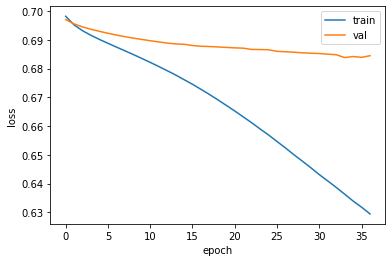

In [27]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.show()

훈련 손실은 꾸준히 감소하고 있지만 검증 손실은 대략 스무 번째 에포크에서 감소가 둔해지고 있는 것을 보아 적절한 에포크에서 훈련을 멈춘 것 같다.<br>
순환 신경망을 성공적으로 훈련시켜서 IMDB 리뷰 데이터를 긍정과 부정으로 분류하는 작업을 수행했다.

그러나 원-핫 인코딩의 단점이 있다. 입력 데이터가 엄청 커진다는 것이다.<br>
토큰 1개를 500차원으로 늘렸기 때문에 약 500배가 커진다.

In [28]:
print(train_seq.nbytes, train_oh.nbytes)

8000000 4000000000


<br><hr><br>

### **단어 임베딩 사용하기**

순환 신경망에서 텍스트를 처리할 때는 **단어 임베딩**을 즐겨 사용한다.<br>
단어 임베딩은 각 단어를 고정된 크기의 실수 벡터로 바꿔준다.

단어 임베딩으로 만들어진 벡터는 원-핫 인코딩된 벡터보다 훨씬 의미있는 값으로 채워지기 때문에 자연어 처리에서 더 좋은 성능을 내는 경우가 많다.

케라스의 Embedding 클래스를 SimpleRNN 층 앞에 추가한 두 번째 순환 신경망을 만들어보자.

In [29]:
model2 = keras.Sequential()
# 임베딩 벡터 크기 = 16
model2.add(keras.layers.Embedding(500, 16, input_length=100))
model2.add(keras.layers.SimpleRNN(8))
model2.add(keras.layers.Dense(1, activation='sigmoid'))

model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 16)           8000      
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 8)                 200       
                                                                 
 dense_1 (Dense)             (None, 1)                 9         
                                                                 
Total params: 8,209
Trainable params: 8,209
Non-trainable params: 0
_________________________________________________________________


**모델 파라미터 개수 계산**
- Embedding 클래스는 500개의 각 토큰을 크기가 16인 벡터로 변경하기 때문에 총 `500 * 16 = 8,000`개의 모델 파라미터를 가진다.
- SimpleRNN 층은 임베딩 벡터의 크기가 16이므로 8개의 뉴런과 곱하기 위해 필요한 가중치 `16 * 8 =128`개를 가진다.
- 은닉 상태에 곱해지는 가중치 `8 * 8 =64`개
- 8개의 절편이 있으므로 이 순환층에 있는 전체 모델 파라미터의 개수는 `128 + 4 + 8 = 200`개 이다.
- 마지막 Dense 층의 가중치 개수는 이전과 동일하게 9개이다.

모델 훈련 과정은 이전과 동일하다.

In [30]:
rmsprop = keras.optimizers.RMSprop(learning_rate=1e-4)
model2.compile(optimizer=rmsprop, loss='binary_crossentropy', 
               metrics=['accuracy'])
checkpoint_cb = keras.callbacks.ModelCheckpoint('best-embedding-model.h5', 
                                                save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=3,
                                                  restore_best_weights=True)

history = model2.fit(train_seq, train_target, epochs=100, batch_size=64,
                     validation_data=(val_seq, val_target),
                     callbacks=[checkpoint_cb, early_stopping_cb])

Epoch 1/100
313/313 [==============================] - 32s 100ms/step - loss: 0.6885 - accuracy: 0.5405 - val_loss: 0.6705 - val_accuracy: 0.6190
Epoch 2/100
313/313 [==============================] - 31s 97ms/step - loss: 0.6562 - accuracy: 0.6473 - val_loss: 0.6413 - val_accuracy: 0.6702
Epoch 3/100
313/313 [==============================] - 31s 100ms/step - loss: 0.6259 - accuracy: 0.6965 - val_loss: 0.6196 - val_accuracy: 0.6986
Epoch 4/100
313/313 [==============================] - 30s 97ms/step - loss: 0.5991 - accuracy: 0.7269 - val_loss: 0.5964 - val_accuracy: 0.7206
Epoch 5/100
313/313 [==============================] - 30s 97ms/step - loss: 0.5764 - accuracy: 0.7476 - val_loss: 0.5730 - val_accuracy: 0.7472
Epoch 6/100
313/313 [==============================] - 31s 99ms/step - loss: 0.5575 - accuracy: 0.7581 - val_loss: 0.5569 - val_accuracy: 0.7500
Epoch 7/100
313/313 [==============================] - 31s 98ms/step - loss: 0.5405 - accuracy: 0.7657 - val_loss: 0.5411 - val_

출력 결과를 보면 원-핫 인코딩을 사용한 모델과 비슷한 성능을 냈다.<br>
반면 순환층의 가중치 개수는 훨씬 작고 훈련 세트 크기도 훨씬 줄어들었다.

훈련 손실과 검증 손실을 그래프로 출력해보자.

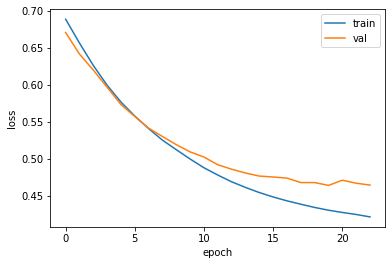

In [31]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.show()

검증 손실이 더 감소되지 않아 훈련이 적절히 조기 종료된 것 같다.<br>
이에 비해 훈련 손실은 계속 감소되고 있다.